# Data Cleaning Notebook

## Objectives

* Data Exploration using ProfileReport
* Correlation and PPS Analysis
* Detailed evaluation of missing data
* Imputing strategies for missing data
* Split Train and Test Sets

## Inputs

* outputs/datasets/collection/house_prices_records.csv 

## Outputs

* Generate cleaned Train and Test sets, saved under outputs/datasets/cleaned 

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 


---

In [1]:
# import all necessary packages and libraries for the notebook
import os
import pandas as pd
from ydata_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps
# import pingouin as pg
sns.set(style="whitegrid")


# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
current_dir = os.getcwd()
current_dir

'/workspaces/heritage-housing-PP5/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspaces/heritage-housing-PP5'

# Load collected data

In [5]:
df_raw_path = "outputs/datasets/collection/house_prices_records.csv"
df = pd.read_csv(df_raw_path)
df.head(3)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500


---

# Data Exploration

We use ProfileReport to get more familiar with the dataset. It will tell use variable types and distribution, missing data levels, etc.

In [ ]:
pandas_report = ProfileReport(df=df, minimal=True)
pandas_report.to_notebook_iframe()

The report on the data set reveals that of the 24 columns, 20 contain numerical values and 4 text/categorical values. A closer look at the detailed information on each variable shows that two of the numerical variables, OverallCond and OverallQual, are also categorical data, which are encoded numerically. Overall approximately 10% of data are missing.

# Correlation and PPS Analysis

We carry out an initial assessment of the relationship between the different variables/features/data. We use custom functions from the CI Walkthrough project 2.

In [6]:
def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)


We use CalculateCorrAndPPS function to calculate Correlations and Predictive Power Score.

In [7]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

/home/codeany/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/home/codeany/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/home/codeany/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/home/codeany/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/home/codeany/.local

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  552.0  0.055  0.104  0.0  0.0  0.0  0.066  0.702




* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



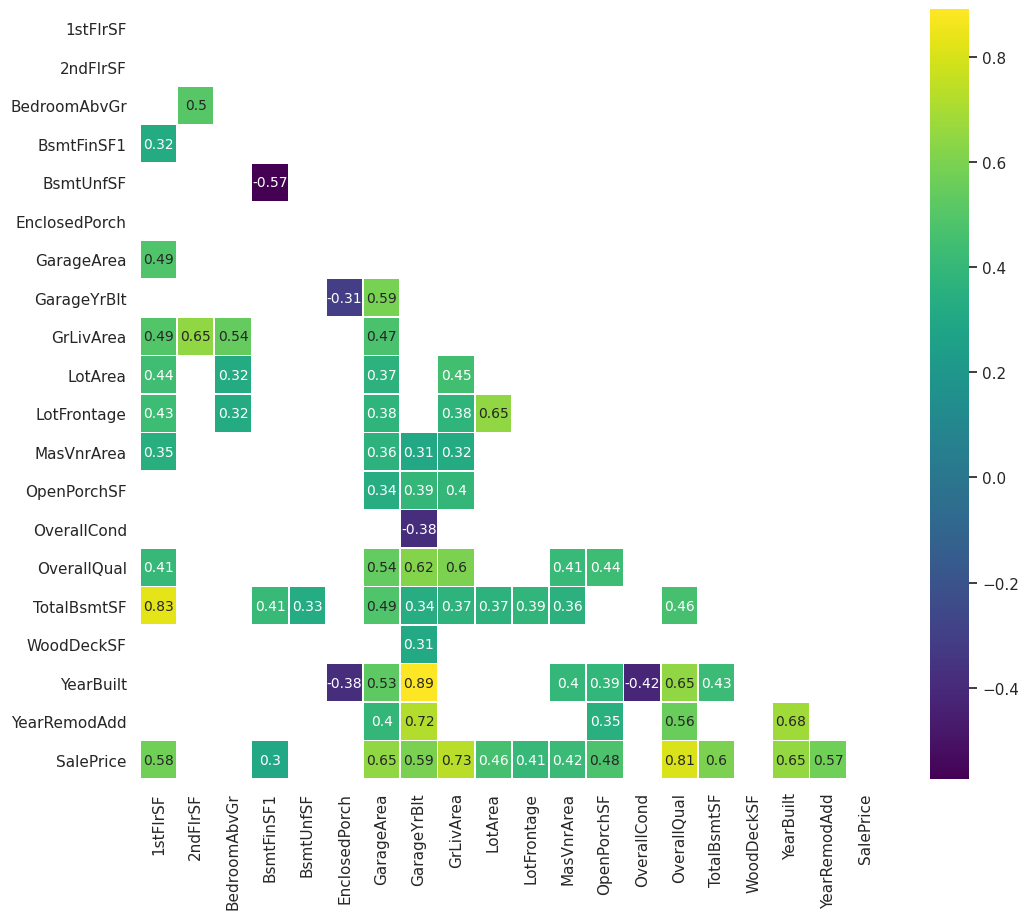



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



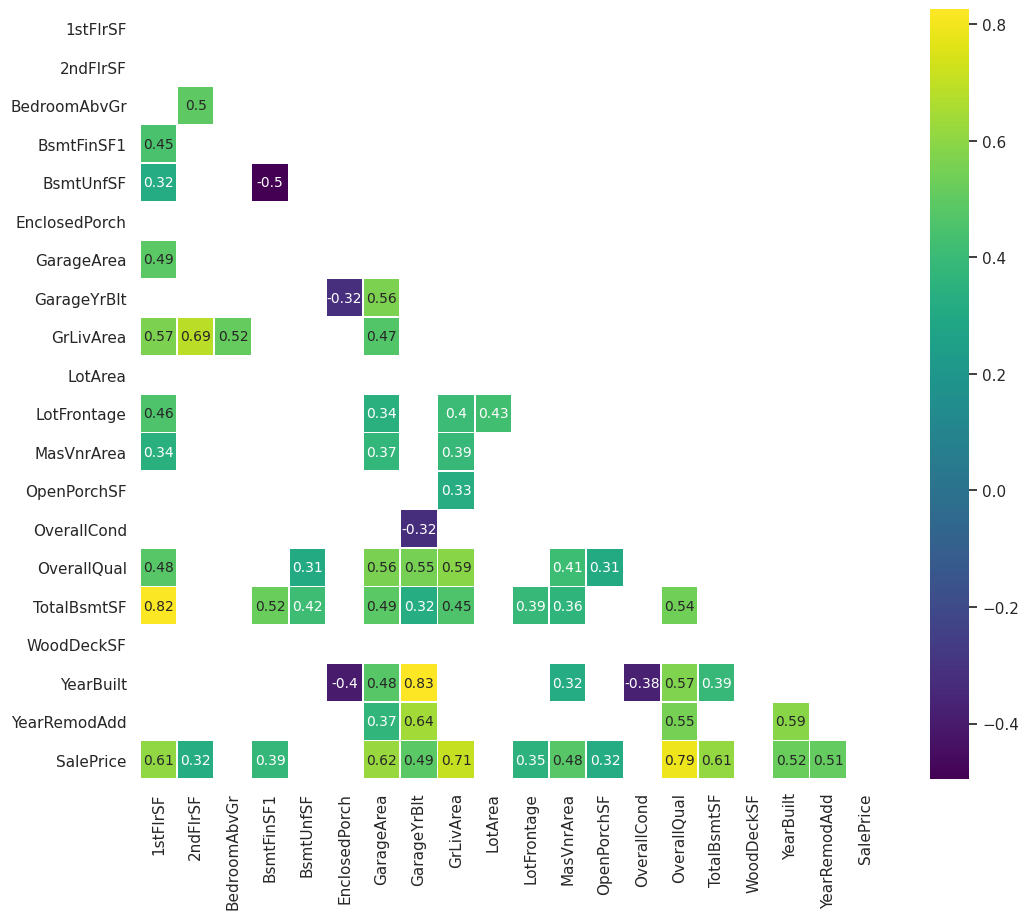



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



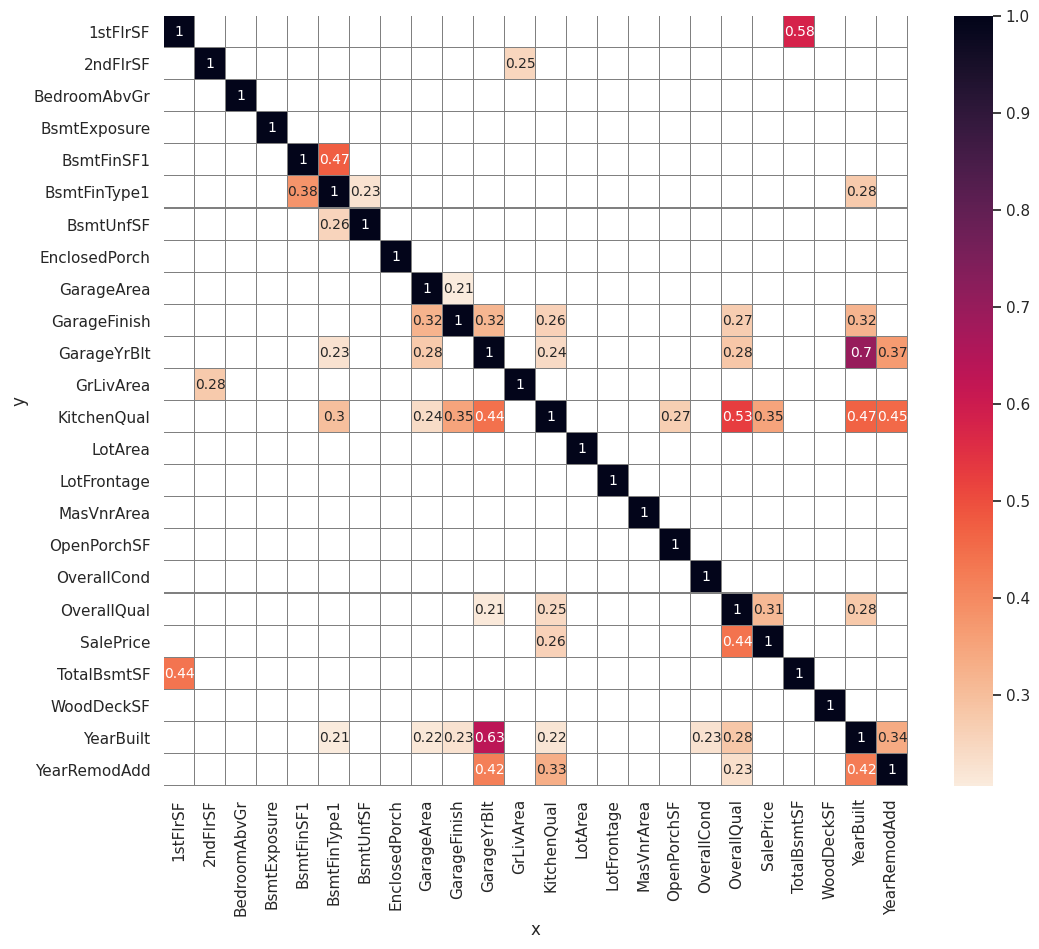

In [10]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman,
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.3, PPS_Threshold = 0.2,
                  figsize=(12,10), font_annot = 10)

# Reports on variables with missing data

In [ ]:
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

In [ ]:
if vars_with_missing_data:
    profile = ProfileReport(df=df[vars_with_missing_data], minimal=True)
    profile.to_notebook_iframe()
else:
    print("There are no variables with missing data")

A closer look at the columns with missing data shows that in total 9 columns are missing data and a total of roughly 26% of cells are missing data. 

Another, more concise, way to look at the missing data is with the custom function from the CI Walkthrough Project 2, called EvaluateMissingData. It evalutes the number of missing data values for each variable and the overall percentage of missing data for each variable. I returns the values in a padas dataframe.

In [ ]:
def EvaluateMissingData(df):
    missing_data_absolute = df.isnull().sum()
    missing_data_percentage = round(missing_data_absolute/len(df)*100, 2)
    df_missing_data = (pd.DataFrame(
        data={"RowsWithMissingData": missing_data_absolute,
              "PercentageOfDataset": missing_data_percentage,
              "DataType": df.dtypes}
    )
                       .sort_values(by=['PercentageOfDataset'], ascending=False)
                       .query("PercentageOfDataset > 0")
                      )
    return df_missing_data
    

In [ ]:
EvaluateMissingData(df)

## Proposal for cleaning/imputing missing data

Data collection is expensive and data is valuable, therefore we want to preserve as much of it as possible and instead of dropping data instances or deleting variables from the data set, we will assess how we can best impute the missing values. A detailed discussion of options follows for each variable with missing data.

### Enclosed Porch Square Feet - 90.68% of data missing

The variable EnclosedPorch is missing a significant amount of data 90.68%. We have two options, firstly we can drop the variable, due to the large amount of missing data. Secondly we can make the assumption that a missing value means that there is no enclosed porch and thus set the missing value to 0. Due to the large percentage of missig values we will initially drop the feature from the analysis.

### Wood Deck Area Square Feet - 89.38% of data missing

We can employ the same options and reasoning for handling the missing data of the variable WoodDeckSF as we did for the previous variable. As before we will opt to drop this variable due to the significant amount of missing data.

### Lot Frontage in Linear Feet - 17.74% of data missing

The mean of the data is 70 and the median 69, the std is 24.3. Due to skewness and kurtosis the data do not seem to have a normal distribution and the median should be imputed.

### Garage Finish - 11.1% of data missing

A more detailed analysis of property attributes related to garage, shows that some of the missing data have a Garage area of 0, meaning there is no garage. The best approach would probably be a proportional assignment based on the already existing distribution of Garage Finish types, or to use a machine model to predict the garage finish based on the wealth of the other features present. For now and for simplicity we will impute the most common value of 'Unfished'. 

### Basement Finish Type - 7.81% of data missig

Similarly to our discussion for the previous variable we can take several approaches to imputing the missing values, for simplicity we will use the most common value 'Unf' (Unfinished).

### Bedrooms Above Ground - 6.78% of data missing

The data have a mean of 2.9, a median of 3 and a std of 0.8. We can use the median imputation in this case.

### 2nd Floor Square Feet 5.89% of data missing

Over 50% of the data are 0, indicating that no second floor is present. The assumption can be that the missing data also mean that no second floor is present and we impute 0 for the missing values.

### Garage Year Built - 5.55% of data missing

Not surprisingly there is a strong correlation between the year the property was built and the year the garage was built, there could thus be an arguement made for using a machine model to predict the year the garage was built and imputing it that way. For implicity we will impute the median for now.

### Masonry Veneer Area in Square Feet - 0.55% of data missing

Most values that are present are zero indicating that there is no masonry veneer area present at the property, as a result we can assume that this is also the case for the missing values and impute them with 0.

## Detailed look at Garage and Basement attributes

In the following cell we replace missing values in the BasementType and GarageFinish categories by the string 'Missing' and plot the type of basement finish against finished and unfinished basement square footage. We can see that some basements in the missing category have finished and some have unfinished square footage, this may give us a more nuanced idea what values to replace the missing data with. However, since the correlation analysis showes that these variables do not have strong correlation with the sale price of the properties it may make sense to simply impute the values of the most common type of basement finish with is unfinished (UNF).

In [ ]:
df_missing = df
df_missing['BsmtFinType1']=df_missing['BsmtFinType1'].fillna('Missing')
df_missing['GarageFinish']=df_missing['GarageFinish'].fillna('Missing')
# df_missing['GarageYrBlt']=df_missing['GarageYrBlt'].fillna(1800)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,12))
sns.boxplot(data=df_missing, x='BsmtFinType1', y='BsmtFinSF1', ax=axes[0,0])
sns.boxplot(data=df_missing, x='BsmtFinType1', y='BsmtUnfSF', ax=axes[1,0])
sns.boxplot(data=df_missing, x='BsmtFinType1', y='SalePrice', ax=axes[2,0])

sns.boxplot(data=df_missing, x='GarageFinish', y='GarageArea', ax=axes[0,1])
sns.boxplot(data=df_missing, x='GarageFinish', y='GarageYrBlt', ax=axes[1,1])
sns.boxplot(data=df_missing, x='GarageFinish', y='SalePrice', ax=axes[2,1])


In [ ]:
pg.normality(df, dv='SalePrice',group='BsmtFinType1', alpha =0.05)

In [ ]:
pg.kruskal(data=df, dv='SalePrice', between='BsmtFinType1')

## Assessing the effects of the proposed data cleaning and imputation

We carry out the following steps in the data cleaning assessment:

1. Drop data that will not be used.
2. Select an imputation method to apply to specific variables.
3. Create a separate dataframe to apply the method
4. Assess the effect of the imputation on the variable distribution

To clean the data and assess the effects of the cleaning we use the 'DataCleaningEffect()' function from the Code Insititute's Feature Engine module. 

In [ ]:
def DataCleaningEffect(df_original,df_cleaned,variables_applied_with_method):

  flag_count=1 # Indicate plot number
  
  # distinguish between numerical and categorical variables
  categorical_variables = df_original.select_dtypes(exclude=['number']).columns 

  # scan over variables, 
    # first on variables that you applied the method
    # if the variable is a numerical plot, a histogram if categorical plot a barplot
  for set_of_variables in [variables_applied_with_method]:
    print("\n=====================================================================================")
    print(f"* Distribution Effect Analysis After Data Cleaning Method in the following variables:")
    print(f"{set_of_variables} \n\n")
  

    for var in set_of_variables:
      if var in categorical_variables:  # it is categorical variable: barplot
        
        df1 = pd.DataFrame({"Type":"Original","Value":df_original[var]})
        df2 = pd.DataFrame({"Type":"Cleaned","Value":df_cleaned[var]})
        dfAux = pd.concat([df1, df2], axis=0)
        fig , axes = plt.subplots(figsize=(15, 5))
        sns.countplot(hue='Type', data=dfAux, x="Value",palette=['#432371',"#FAAE7B"])
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.xticks(rotation=90)
        plt.legend() 

      else: # it is numerical variable: histogram

        fig , axes = plt.subplots(figsize=(10, 5))
        sns.histplot(data=df_original, x=var, color="#432371", label='Original', kde=True,element="step", ax=axes)
        sns.histplot(data=df_cleaned, x=var, color="#FAAE7B", label='Cleaned', kde=True,element="step", ax=axes)
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.legend() 

      plt.show()
      flag_count+= 1

## Drop Variables

- We will drop the varaibles 'EnclosedPorch' and 'WoodDeckSF' since they have more than 80% of data missing from each column.
- The imputation approach is **Drop Variables**
- Select variables to apply the imputation approach
- Create new data frame and apply the imputation to the selected variables
- Inspect the new data frame

In [ ]:
from feature_engine.selection import DropFeatures

variables_method = ['EnclosedPorch', 'WoodDeckSF']
variables_method

imputer = DropFeatures(features_to_drop=variables_method)
df_method = imputer.fit_transform(df)
df_method.head(5)


## Arbitrary Number Imputation

- We will impute the number '0' for the following variables '2ndFlrSF' and 'MasVnrArea'.
- The imputation approach is **ArbitraryNumberImputer**
- Select variables to apply the imputation approach
- Create new data frame and apply the imputation to the selected variables
- Assess the effect of the data imputation

In [ ]:
from feature_engine.imputation import ArbitraryNumberImputer

variables_method = ['2ndFlrSF', 'MasVnrArea']
variables_method

imputer = ArbitraryNumberImputer(arbitrary_number=0, variables=variables_method)
df_method = imputer.fit_transform(df)

DataCleaningEffect(df_original=df,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_method)




## Categorical Imputation
- We will impute the category 'Unf' for the following variables 'BsmtFinType1' and 'GarageFinish'.
- The imputation approach is **CategoricalImputer**
- Select variables to apply the imputation approach
- Create new data frame and apply the imputation to the selected variables
- Assess the effect of the data imputation


In [ ]:
from feature_engine.imputation import CategoricalImputer

variables_method = ['BsmtFinType1', 'GarageFinish']
variables_method

imputer = CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=variables_method)
df_method = imputer.fit_transform(df)

DataCleaningEffect(df_original=df,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_method)


## Median Imputation
- We will impute the median for the following variables 'BedroomAbvGr', 'GarageYrBlt' and 'LotFrontage'.
- The imputation approach is **MeanMedianImputer**
- Select variables to apply the imputation approach
- Create new data frame and apply the imputation to the selected variables
- Assess the effect of the data imputation


In [ ]:
from feature_engine.imputation import MeanMedianImputer

variables_method = ['BedroomAbvGr', 'GarageYrBlt', 'LotFrontage']
variables_method

imputer = MeanMedianImputer(imputation_method='median', variables=variables_method)
df_method = imputer.fit_transform(df)

DataCleaningEffect(df_original=df,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_method)


# Train and Test Split
- Next we split the data into train and test sets

In [ ]:
from sklearn.model_selection import train_test_split

TrainSet, TestSet, _, __ = train_test_split(
                                        df,
                                        df['SalePrice'],
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

- Now we apply the changes from the various imputation methods to the train and test sets.

In [ ]:
# Drop Variables ['EnclosedPorch', 'WoodDeckSF']
variables_method = ['EnclosedPorch', 'WoodDeckSF']
imputer = DropFeatures(features_to_drop=variables_method)
imputer.fit(TrainSet)
TrainSet, TestSet = imputer.transform(TrainSet), imputer.transform(TestSet)

# ArbitraryNumberImputer 
variables_method = ['2ndFlrSF','MasVnrArea']
imputer = ArbitraryNumberImputer(arbitrary_number=0, variables=variables_method)
imputer.fit(TrainSet)
TrainSet, TestSet = imputer.transform(TrainSet) , imputer.transform(TestSet)

# CategoricalImputer
variables_method = ['BsmtFinType1', 'GarageFinish']
imputer = CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=variables_method)
imputer.fit(TrainSet)
TrainSet, TestSet = imputer.transform(TrainSet) , imputer.transform(TestSet)

# MeanMedianImputer
variables_method = ['BedroomAbvGr', 'GarageYrBlt', 'LotFrontage']
imputer = MeanMedianImputer(imputation_method='median', variables=variables_method)
imputer.fit(TrainSet)
TrainSet, TestSet = imputer.transform(TrainSet) , imputer.transform(TestSet)

- Check for missing data one more time

In [ ]:
df_missing_data = EvaluateMissingData(TrainSet)
print(f"* There are {df_missing_data.shape[0]} variables with missing data \n")
df_missing_data

---

## Proposed Data Cleaning Pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropFeatures
from feature_engine.imputation import MeanMedianImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.imputation import ArbitraryNumberImputer


data_cleaning_pipeline = Pipeline([
      ( 'DropFeatures', DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF']) ),
      ( 'MeanMedianImputer', MeanMedianImputer(imputation_method='median', variables=['BedroomAbvGr', 'GarageYrBlt', 'LotFrontage']) ),
      ( 'CategoricalImputer', CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=['BsmtFinType1', 'GarageFinish']) ),
      ( 'ArbitraryNumberImputer', ArbitraryNumberImputer(arbitrary_number=0, variables=['2ndFlrSF','MasVnrArea']) ),
])

df = data_cleaning_pipeline.fit_transform(df)

---

# Push files to Repo

- Save the cleaned Test and Train Sets to your workspace.
- Then push all files to the repository.

In [ ]:
try:
  # create here your folder
  os.makedirs(name='outputs/datasets/cleaned')
except Exception as e:
  print(e)

# Save the Train Set
TrainSet.to_csv("outputs/datasets/cleaned/TrainSetCleaned.csv", index=False)

# Save the Test Set
TestSet.to_csv("outputs/datasets/cleaned/TestSetCleaned.csv", index=False)
